# Предсказание с использованием модели COLES

Этот ноутбук демонстрирует процесс генерации эмбеддингов с помощью предобученной модели COLES и последующего обучения классификатора на этих эмбеддингах.

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Sampler
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from imblearn.over_sampling import ADASYN
from catboost import CatBoostClassifier
import pytorch_lightning as pl
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames import PtlsDataModule
from ptls.frames.coles import CoLESModule, ColesDataset
from ptls.frames.coles.split_strategy import SplitByNearestTime
from ptls.data_load.datasets import MemoryMapDataset, ParquetDataset, ParquetFiles
from ptls.data_load.iterable_processing import SeqLenFilter, FeatureFilter
from ptls.data_load.utils import collate_feature_dict
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
df = pd.read_parquet('output/preprocessed_filtered_df.parquet') 

unk_action = df['action'].explode().nunique()
df['count_action'] = df['action'].apply(lambda x: len(x))
print('Статитстика по всем экшенам пользователей')
print(df['count_action'].describe())
print('Количество уникальных экшенов:', unk_action)

Статитстика по всем экшенам пользователей
count    279271.000000
mean         87.953687
std         521.905735
min           1.000000
25%           2.000000
50%           8.000000
75%          36.000000
max      139513.000000
Name: count_action, dtype: float64
Количество уникальных экшенов: 2038


## Примеры данных

### Для обучения эмбедингов (экшены пользователей за все время)

In [ ]:

emb_df = pd.read_parquet('output/preprocessed_filtered_df.parquet')[['guid', 'event_time', 'action']]
emb_df.head()

,guid,event_time,action
0,018780a7-f2ad-d80c-0d77-5945a3e6bf3e,[1715140642],[10]
1,018780a8-77c2-16a8-e6f2-4d050736adf0,"[1714534955, 1714534955, 1714539332, 171453933...","[168, 168, 22, 22, 11, 11, 86, 86, 72, 72, 94,..."
2,018783bc-21e1-04f7-cd30-1e18ff0cb84f,"[1714539964, 1714539964, 1714656268, 171465626...","[45, 45, 113, 113, 1, 1, 1, 1, 13, 13, 13, 13,..."
3,018783bc-2c5d-c820-0565-57247843ce08,"[1714543899, 1714543899, 1714708352, 171506463...","[7, 7, 7, 7, 7, 7, 7]"
4,018783bc-4761-c227-d313-1e2cd56ea2b8,"[1715227287, 1715227287, 1715228548, 171523146...","[192, 192, 63, 63, 59, 63, 63, 63, 59, 59, 63,..."


### Для обучения классификации (Экшены за неделю до оффера)

In [ ]:
cls_df = (pd.read_parquet('output/preprocessed_filtered_df.parquet')
          .assign(result=lambda x: x['result'].apply(lambda y: y[0]))
          )
cls_df.head()

,guid,event_time,action,result
0,018780a7-f2ad-d80c-0d77-5945a3e6bf3e,[1715140642],[10],0
1,018780a8-77c2-16a8-e6f2-4d050736adf0,"[1714534955, 1714534955, 1714539332, 171453933...","[168, 168, 22, 22, 11, 11, 86, 86, 72, 72, 94,...",0
2,018783bc-21e1-04f7-cd30-1e18ff0cb84f,"[1714539964, 1714539964, 1714656268, 171465626...","[45, 45, 113, 113, 1, 1, 1, 1, 13, 13, 13, 13,...",0
3,018783bc-2c5d-c820-0565-57247843ce08,"[1714543899, 1714543899, 1714708352, 171506463...","[7, 7, 7, 7, 7, 7, 7]",0
4,018783bc-4761-c227-d313-1e2cd56ea2b8,"[1715227287, 1715227287, 1715228548, 171523146...","[192, 192, 63, 63, 59, 63, 63, 63, 59, 59, 63,...",0


## Обучение эмбеддингов COLES 


In [ ]:
data_path = 'output/preprocessed_filtered_df.parquet'

iterable_train = ParquetDataset(ParquetFiles(data_path))

map_processed_train = MemoryMapDataset(
    data=iterable_train,
    i_filters=[
        SeqLenFilter(min_seq_len=100),
    ],
)

trx_encoder_params = dict(
    embeddings_noise=0.006,
    embeddings={
        "action": {"in": unk_action, "out": 64},  # 256
    },
)

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    bidir=False,
    hidden_size=128,
    type="gru",
)

model = CoLESModule(
    seq_encoder=seq_encoder,
    optimizer_partial=partial(torch.optim.Adam, lr=0.001),
    lr_scheduler_partial=partial(
        torch.optim.lr_scheduler.StepLR, step_size=10, gamma=0.95
    ),
)
                                                                                                                                                                                                                                                                                                                                                                                                                               
train_dataset = ColesDataset(                                                                                                                      
     data=map_processed_train,                                                                                                                      
     splitter=SplitByNearestTime(                                                                                                                   
         split_count=3,                                                                                                                             
         cnt_min= 50,                                                                                                                                
         cnt_max=1000,                                                                                                                               
         margin= 60*1                                                                                                                         
     ),                                                                                                                                             
     col_time='event_time'                                                                                                                          
 )    

# Создаём загрузчик данных для обучения
train_dl = PtlsDataModule(
    train_data=train_dataset,
    train_num_workers=4,  
    train_batch_size=128,
    
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(                                                                                               
 dirpath="checkpoints",                                                                                                                        
 filename="coles_model-{epoch:02d}-{val_loss:.2f}",                                                                                            
 save_top_k=1,                                                                                                                                 
 monitor="val_loss",                                                                                                                           
)  

trainer = pl.Trainer(max_epochs=10, callbacks=[checkpoint_callback])
trainer.fit(model, train_dataloaders=train_dl)


torch.save(model.state_dict(), 'coles_model_state_dict.pth') 

## Подготовка данных и обучение классификатора


In [7]:
import numpy as np

class_df = pd.read_parquet('output/preprocessed_classifier_data.parquet')[['offer_date', 'event_time', 'action', 'result']]
# Получение эмбедингов
class_df['result'] = class_df['result'].apply(lambda x: x[0])
print("Медианное количество экшенов за неделю", class_df['action'].apply(lambda x: np.mean(x)).median())
print("Среднее количество экшенов за неделю", class_df['action'].apply(lambda x: np.mean(x)).mean())

Медианное количество экшенов за неделю 44.8768115942029
Среднее количество экшенов за неделю 59.73106208899581


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, max_len=150, filter_result=None):
        self.dataframe = dataframe
        self.max_len = max_len

        # применение фильтра на таргет
        if filter_result is not None:
           self.dataframe = self.dataframe[self.dataframe['result'] == filter_result]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        action_sequence = self.dataframe['action'].iloc[idx]
        target_label = self.dataframe['result'].iloc[idx]

        # обрезка больших последовательностей
        if len(action_sequence) > self.max_len:
            action_sequence = action_sequence[-self.max_len:] 

        action_sequence = torch.tensor(action_sequence, dtype=torch.long)
        target_label = torch.tensor(target_label, dtype=torch.long)

        return {"action": action_sequence, "target":target_label}

# Функция для вычисления эмбеддингов по всему даталоадеру
def get_embeddings(model, dataloader):
    model.eval()
    embeddings = []
    targets = []
    with torch.no_grad():
        for batch in dataloader:
            emb = model.seq_encoder(batch)  # Вычисляем эмбеддинги для батча
            embeddings.append(emb.detach().cpu().numpy())
            targets.append(batch.payload['target'].detach().cpu().numpy())
    embeddings = np.concatenate(embeddings, axis=0)
    targets = np.concatenate(targets, axis=0)
    return embeddings, targets


class_df = pd.read_parquet('output/preprocessed_classifier_data.parquet')[['offer_date', 'event_time', 'action', 'result']] 
class_df['result'] = class_df['result'].apply(lambda x: x[0])

dataset_result_1 = CustomDataset(class_df, filter_result=1)
dataset_result_0 = CustomDataset(class_df, filter_result=0)

# Создаем DataLoader для каждого класса 
dataloader_class_1 = DataLoader(dataset_result_1, batch_size=500, collate_fn=collate_feature_dict)
dataloader_class_0 = DataLoader(dataset_result_0, batch_size=500, collate_fn=collate_feature_dict)

# Вычисляем эмбеддинги для каждого класса
embeddings_1, targets_1 = get_embeddings(model, dataloader_class_1)
embeddings_0, targets_0 = get_embeddings(model, dataloader_class_0)

# Собираем единый датасет
X = np.concatenate([embeddings_1, embeddings_0], axis=0)
y = np.concatenate([targets_1, targets_0], axis=0)

print("Размер исходного датасета: X =", X.shape, ", y =", y.shape)

# Разделим исходный датасет на обучающую и валидационную выборки (с сохранением соотношения классов)
X_train_orig, X_val, y_train_orig, y_val = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42, shuffle=True
)


Размер исходного датасета: X = (49145, 256) , y = (49145,)


In [ ]:
print("Размер обучающей выборки до ресэмплинга: X_train =", X_train_orig.shape, ", y_train =", y_train_orig.shape)

adasyn = ADASYN(sampling_strategy=0.5, random_state=42)
X_train_resample, y_train_resample = adasyn.fit_resample(X_train_orig, y_train_orig)

print("Размер обучающей выборки после ADASYN: X_train =", X_train_resample.shape, ", y_train =", y_train_resample.shape)
print("Распределение классов после ADASYN:", dict(zip(*np.unique(y_train_resample, return_counts=True))))

class_weights = [1.0, 1.4]
print("Используемые веса классов:", class_weights)

# Обучаем модель CatBoost на данных после SMOTE
model_cb = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.005,
    depth=7,
    loss_function='Logloss',
    eval_metric='F1',
    # scale_pos_weight = 10,
    class_weights=class_weights,
    random_seed=42,
    verbose=100
)

model_cb.fit(X_train_resample, y_train_resample, eval_set=(X_val, y_val), verbose=100)

y_pred = model_cb.predict(X_val)
f1 = f1_score(y_val, y_pred)
print("F1 score на валидационной выборке:", f1)


Размер обучающей выборки до ресэмплинга: X_train = (44230, 256) , y_train = (44230,)
Размер обучающей выборки после ADASYN: X_train = (62955, 256) , y_train = (62955,)
Распределение классов после ADASYN: {0: 42423, 1: 20532}
Используемые веса классов: [1.0, 1.4]
0:	learn: 0.4726639	test: 0.1245889	best: 0.1245889 (0)	total: 174ms	remaining: 5m 47s
100:	learn: 0.5493611	test: 0.1591647	best: 0.1617749 (91)	total: 8.73s	remaining: 2m 44s
200:	learn: 0.5769490	test: 0.1612565	best: 0.1654064 (115)	total: 17.5s	remaining: 2m 36s
300:	learn: 0.6028587	test: 0.1640479	best: 0.1654064 (115)	total: 25.6s	remaining: 2m 24s
400:	learn: 0.6266739	test: 0.1701783	best: 0.1736317 (374)	total: 33.6s	remaining: 2m 13s
500:	learn: 0.6491732	test: 0.1614941	best: 0.1741011 (413)	total: 41.6s	remaining: 2m 4s
600:	learn: 0.6690496	test: 0.1563372	best: 0.1741011 (413)	total: 50s	remaining: 1m 56s
700:	learn: 0.6886774	test: 0.1507936	best: 0.1741011 (413)	total: 58s	remaining: 1m 47s
800:	learn: 0.70602

## Оценка классификатора

В этом разделе оценивается производительность обученного классификатора CatBoost с использованием precision, recall и матрицы ошибок

Precision: 0.1045
Recall: 0.2289


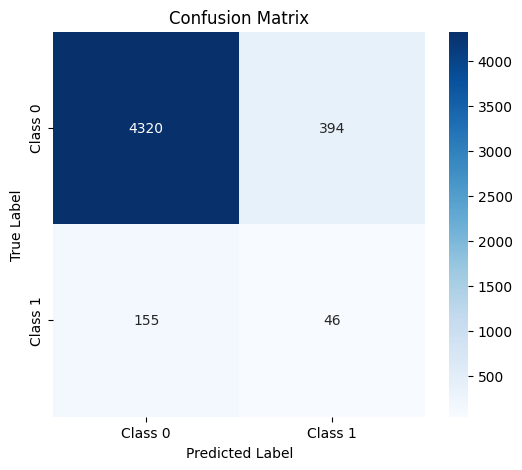

In [ ]:
# Рассчитываем метрики
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred)

# Выводим precision и recall
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Визуализируем confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## Визуальное представление эмбедингов событий за неделю до оффера с результатом (приняли оффер или нет)
- синие точки:  оффер не приняли
- красные: приняли

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

def calculate_mean_distances(embeddings_0, embeddings_1, sample_size=1000):
    """
    Calculates mean Euclidean distances within groups of multi-dimensional embeddings.

    Args:
        embeddings_0: NumPy array of embeddings for not accepted offers (shape: (n_samples, n_features)).
        embeddings_1: NumPy array of embeddings for accepted offers (shape: (n_samples, n_features)).
        sample_size: Number of embeddings to sample from each group (default 1000).

    Returns:
        Tuple: (mean_accepted_distance, mean_not_accepted_distance). Returns (0,0) if insufficient data.
    """
    #Handle insufficient data
    if len(embeddings_0) < sample_size or len(embeddings_1) < sample_size:
        return 0, 0

    n_samples = min(sample_size, len(embeddings_0), len(embeddings_1))
    
    # Sample indices
    idx_0 = np.random.choice(len(embeddings_0), size=n_samples, replace=False)
    idx_1 = np.random.choice(len(embeddings_1), size=n_samples, replace=False)

    #Sample embeddings using indices
    accepted_sample = embeddings_1[idx_1]
    not_accepted_sample = embeddings_0[idx_0]

    #Calculate distances (index-based sampling already handles dimensionality)
    accepted_distances = euclidean_distances(accepted_sample)
    not_accepted_distances = euclidean_distances(not_accepted_sample)


    def mean_distance(distances):
        distances_flat = distances.flatten()
        distances_non_zero = distances_flat[distances_flat != 0]
        return np.mean(distances_non_zero) if len(distances_non_zero) > 0 else 0

    mean_accepted_distance = mean_distance(accepted_distances)
    mean_not_accepted_distance = mean_distance(not_accepted_distances)

    return mean_accepted_distance, mean_not_accepted_distance

def visualize_embeddings_with_cross_distances(embeddings_0, embeddings_1, sample_size=10000):
    #Check for sufficient data
    if len(embeddings_0) < sample_size or len(embeddings_1) < sample_size:
        print("Insufficient data for sampling. Increase sample_size or provide more data.")
        return

    n_samples = min(sample_size, len(embeddings_0), len(embeddings_1))
    idx_0 = np.random.choice(len(embeddings_0), size=n_samples, replace=False)
    idx_1 = np.random.choice(len(embeddings_1), size=n_samples, replace=False)

    embeddings_0_sample = embeddings_0[idx_0]
    embeddings_1_sample = embeddings_1[idx_1]

    embeddings = np.concatenate([embeddings_0_sample, embeddings_1_sample], axis=0)
    labels = np.concatenate([np.zeros(n_samples), np.ones(n_samples)])

    # PCA for visualization
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    colors = ['blue' if label == 0 else 'red' for label in labels]
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, alpha=0.7, s=20)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('2D Projection of Embeddings (Sampled)')
    plt.show()

    #Within-group distances (unchanged)
    mean_accepted_distance, mean_not_accepted_distance = calculate_mean_distances(embeddings_0_sample, embeddings_1_sample)
    print(f"Mean distance between accepted offer embeddings: {mean_accepted_distance:.4f}")
    print(f"Mean distance between not accepted offer embeddings: {mean_not_accepted_distance:.4f}")


    #Between-group distances
    cross_distances = euclidean_distances(embeddings_0_sample, embeddings_1_sample)
    mean_cross_distance = np.mean(cross_distances)
    print(f"Mean distance between accepted and not accepted offer embeddings: {mean_cross_distance:.4f}")

visualize_embeddings_with_cross_distances(embeddings_0, embeddings_1, sample_size=2000)

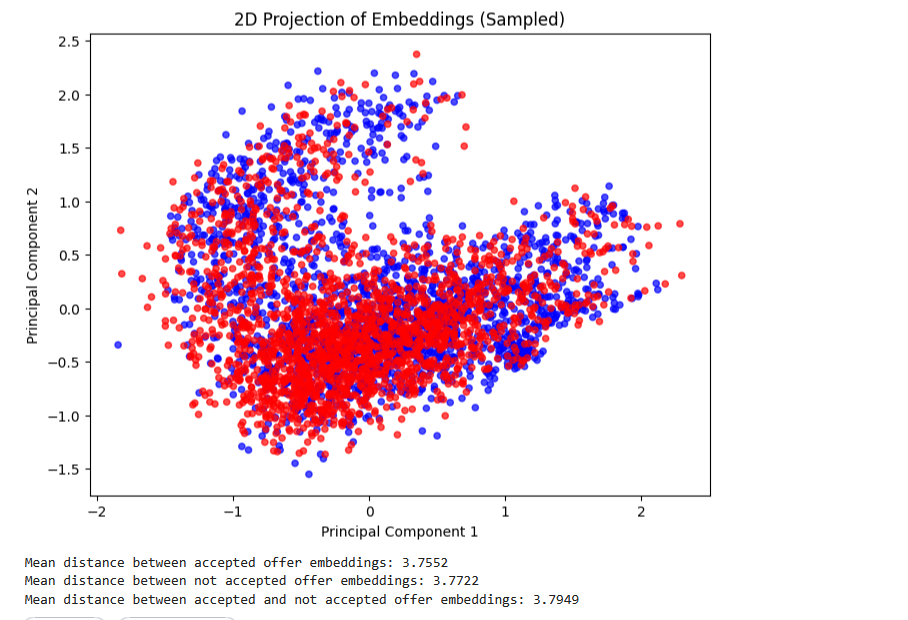